In [1]:
from __future__ import print_function

import os

from time import sleep

import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, ELU, Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1
from tensorflow.keras.utils import load_img, img_to_array

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from os import listdir
from os.path import isfile, join
import re

In [2]:
import joblib

In [3]:
# For Saving
path_name = "/Users/charlielosche/Documents/Flatiron/Flatiron_Repos/Capstone_Project/Notebooks/"    # some path


model_name = 'predict_emotion_2.sav' # I think saving it to sav format maybe will help here

In [4]:
joblib.load(path_name + model_name)

Metal device set to: Apple M1 Pro


2022-09-30 11:54:06.143481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-30 11:54:06.143714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# opening the file- model_jlib
m_jlib = joblib.load(path_name + model_name)

In [6]:
m_jlib

# Prep Prediction Classes

Build test directory to inform class labels

In [7]:
test_data_dir = '../Data/archive_FER_Affect/final_test/'

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Found 4163 images belonging to 7 classes.

nb_train_samples2 = 9601
nb_validation_samples2 = 2276
nb_test_samples = 4163
batch_size = 512

# We need to recreate our test generator with shuffle = false
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 4163 images belonging to 7 classes.


In [10]:
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = m_jlib.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


2022-09-30 11:54:12.648156: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-30 11:54:12.715234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 33s 3s/step


In [11]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [12]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

# Building image show for predictions

In [13]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [14]:
def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if np.array_equal(faces,()):
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

In [15]:
%matplotlib inline

img = cv2.imread("../Data/unseen_images/Paige2_Happy.jpeg")
rects, faces, image = face_detector(img)


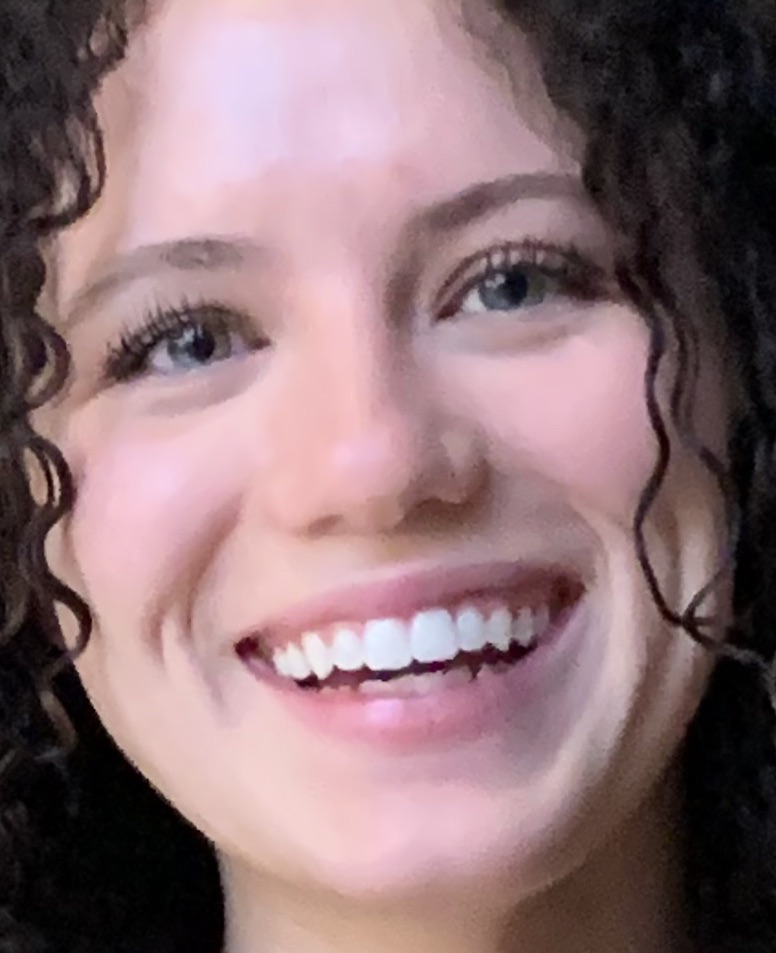

In [16]:
load_img('../Data/unseen_images/Paige2_Happy.jpeg')

In [17]:
type(load_img('../Data/unseen_images/Paige2_Happy.jpeg'))

PIL.JpegImagePlugin.JpegImageFile

1/1 [==============================] - 0s 78ms/step


2022-09-30 11:54:45.722581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


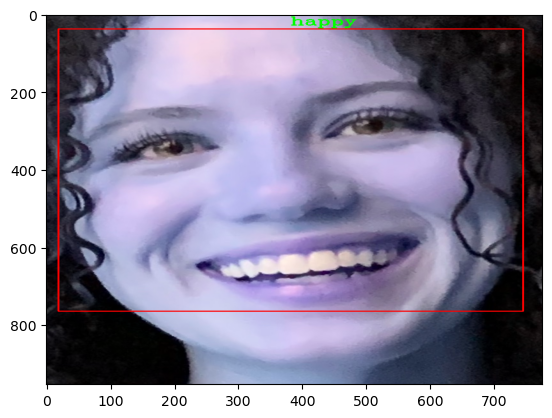

In [18]:

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = m_jlib.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0), 2)
    
    #Show the image with matplotlib
    plt.imshow(image, aspect='auto')
    plt.show()

# That's How It's Done!!!